In [279]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np
import re

In [280]:
def prepare(data):
    
    buildtimes = np.array([1.385, 0.696, 0.766, 0.689, 0.833])
    
    data['buldingtime'] = data['buldingtime'] + buildtimes.mean()
    
    data['import.start'] = pd.to_datetime(data['import.start'])
    data['import.stop'] = pd.to_datetime(data['import.stop'])
    data['created'] = pd.to_datetime(data['created'])
    data['started'] = pd.to_datetime(data['started'])
    data['finished'] = pd.to_datetime(data['finished'])
    
    data['starttime'] = (data['started'] - data['created']).dt.total_seconds() 
    data['dockertime'] = (data['finished'] - data['started']).dt.total_seconds() 
    data['importtime'] = (data['import.stop'] - data['import.start']).dt.total_seconds() 
    
    end2end = pd.DataFrame({'end2end': (data['import.stop'] - data['created']).dt.total_seconds() +1 +data.buldingtime})
    
    started_temp = pd.DataFrame()
    docker_temp = pd.DataFrame()
    import_temp = pd.DataFrame()
    total_temp = pd.DataFrame()
    
    for i in range(8,38,6):
        started_temp.insert(range(8,38,6).index(i), "", (pd.to_datetime(data.iloc[:, i+1]) - pd.to_datetime(data.iloc[:, i])).dt.total_seconds() , True)
        docker_temp.insert(range(8,38,6).index(i), "", (pd.to_datetime(data.iloc[:, i+2]) - pd.to_datetime(data.iloc[:, i+1])).dt.total_seconds() , True)
        import_temp.insert(range(8,38,6).index(i), "", (pd.to_datetime(data.iloc[:, i+4]) - pd.to_datetime(data.iloc[:, i+3])).dt.total_seconds() , True)
        total_temp.insert(range(8,38,6).index(i), "", (pd.to_datetime(data.iloc[:, i+4]) - pd.to_datetime(data.iloc[:, i+1])).dt.total_seconds() +1 , True)
    
    started_temp.columns = ['starttime{}'.format(i) for i in range(1, 6)]
    docker_temp.columns = ['dockertime{}'.format(i) for i in range(1, 6)]
    import_temp.columns = ['importtime{}'.format(i) for i in range(1, 6)]
    total_temp.columns = ['end2end{}'.format(i) for i in range(1, 6)]
    
    data = pd.concat([data, end2end, started_temp, docker_temp, import_temp, total_temp], axis=1)
    
    return data

In [281]:
def display(column, scalar=1):
    import pandas as pd

    mean = scalar*column.mean()
    median = scalar*column.median()
    std = scalar*column.std()
    min_max = [round(scalar*column.min(),2), round(scalar*column.max(),2)]
    custom_desc = f"{round(mean,2)} & {round(median,2)} & {round(std,2)} & {min_max}"
    print(custom_desc)

In [282]:
def extract_imports(imp):
    imp = imp.split("'")
    l = ""
    
    for i in imp:
        if i == "(" or i == ")" or i == ",)" or i == "," or i == "()" or i == ", ":
            continue
        else:
            if l == "":
                l = i
            else:
                l = l + ";" + i
    return l

In [283]:
install = pd.read_csv("experiments/installations.csv")
install_libaries = pd.DataFrame()
for index, row in install.iterrows():
    if pd.isna(row[1]):
        ins = set()
    else: 
        ins = set(row[1].split(";"))
    all = set(row[2].split(";"))
    if pd.isna(row[3]):
        clu = set()
    else: 
        clu = set(row[3].split(";"))
    install_libaries = pd.concat([install_libaries, pd.DataFrame([[row[0], len(ins), len(ins)-0, len(ins)-len(ins.intersection(all)), len(ins)-len(ins.intersection(clu))]])], ignore_index=True)
install_libaries.columns = ['imports', 'toInstall', 'vanilla_approach', 'all_top_10', 'cluster_top_10']

install_libaries

/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_56715/4029374880.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(row[1]):
/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_56715/4029374880.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ins = set(row[1].split(";"))
/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_56715/4029374880.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all

,imports,toInstall,vanilla_approach,all_top_10,cluster_top_10
0,argparse;copy;datetime;funcx;itertools;json;ma...,7,7,4,0
1,argparse;copy;funcx;itertools;json;matplotlib;...,6,6,4,0
2,argparse;sys,1,1,1,0
3,CLEAN,1,1,1,0
4,CLEAN;os,1,1,1,0
...,...,...,...,...,...
202,timeit,0,0,0,0
203,torch,1,1,0,0
204,torch;torchvision,2,2,1,2
205,traceback,0,0,0,0


In [284]:
col = ['imports', 'buldingtime', 'installtime', 'end2end', 
       'starttime', 'dockertime', 'importtime', 
       'starttime1', 'starttime2', 'starttime3', 'starttime4', 'starttime5', 
       'dockertime1', 'dockertime2', 'dockertime3', 'dockertime4', 'dockertime5', 
       'importtime1', 'importtime2', 'importtime3', 'importtime4', 'importtime5', 
       'end2end1', 'end2end2', 'end2end3', 'end2end4', 'end2end5']

In [285]:
data = pd.read_csv("data/every_package/run10.csv")
data = prepare(data)
imp = data[col[0]]
data = data[col[1:]]
for i in range(9, 0, -1):
    tmp = pd.read_csv("data/every_package/run" + str(i) + ".csv")
    tmp = prepare(tmp)
    tmp = tmp[col[1:]]
    data = (data + tmp)
data = data / 10
data.insert(0, col[0], imp)

In [286]:
data.sort_values(by=['imports'], ascending=True)

,imports,buldingtime,installtime,end2end,starttime,dockertime,importtime,starttime1,starttime2,starttime3,...,importtime1,importtime2,importtime3,importtime4,importtime5,end2end1,end2end2,end2end3,end2end4,end2end5
52,PIL,10.9538,6.36,14.244324,2.108298,1.193852,0.013953,0.667763,0.737138,0.742705,...,0.001137,0.000956,0.000969,0.000951,0.001033,1.014857,1.019006,1.015829,1.015196,1.015294
0,argparse,9.2838,5.31,12.507632,2.026819,1.210094,0.044723,0.643705,0.622289,0.749516,...,0.010771,0.011305,0.010256,0.010476,0.009689,1.024725,1.024697,1.025290,1.025126,1.025162
1,clean,10.9838,6.21,14.456444,2.264412,1.225619,0.008079,0.806776,0.811559,0.876272,...,0.000363,0.000313,0.000283,0.000356,0.000386,1.013763,1.013838,1.015388,1.013718,1.013618
2,collections,3.9738,-1.00,8.129689,2.838753,1.332040,0.053543,0.755990,0.707457,0.751481,...,0.017491,0.017785,0.017393,0.017150,0.017925,1.046815,1.047690,1.048248,1.047806,1.047264
3,colmena,19.2038,14.83,22.685633,2.292351,1.201289,0.008861,0.774815,0.751169,0.748512,...,0.000348,0.000371,0.000343,0.000450,0.000418,1.015633,1.014370,1.014037,1.013939,1.013882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,urllib3,9.3338,5.57,13.074337,2.105103,1.662203,0.455932,0.718015,0.659613,0.754252,...,0.079703,0.079253,0.079546,0.079558,0.079631,1.092762,1.092503,1.092950,1.093041,1.092958
88,uuid,10.8538,7.12,14.093022,2.033960,1.218466,0.052394,0.635997,0.656979,0.617127,...,0.011224,0.011740,0.011830,0.012209,0.011898,1.026093,1.025645,1.025738,1.025557,1.026064
89,warnings,3.5238,-1.00,6.923177,2.180663,1.233780,0.000008,0.768780,0.746880,0.726569,...,0.000010,0.000012,0.000008,0.000008,0.000007,1.029219,1.027995,1.029053,1.029911,1.028062
90,webbrowser,3.5538,-1.00,7.236420,2.186071,1.513124,0.239609,0.743873,0.669989,0.748356,...,0.119145,0.124510,0.119990,0.123114,0.121590,1.148651,1.156002,1.156349,1.153022,1.151060


In [287]:
vanilla_approach = pd.read_csv(f"new/vanilla_approach/run10.csv")
all_top_10 = pd.read_csv(f"new/all_top_10/run10.csv")
cluster_top_10 = pd.read_csv(f"new/cluster_top_10/run10.csv")
on_the_fly = pd.read_csv(f"new/on_the_fly/run10.csv")

In [288]:
for run in range(9, 0, -1):
    vanilla_approach = pd.concat([vanilla_approach, pd.read_csv(f"new/vanilla_approach/run{run}.csv")])
    all_top_10 = pd.concat([all_top_10, pd.read_csv(f"new/all_top_10/run{run}.csv")])
    cluster_top_10 = pd.concat([cluster_top_10, pd.read_csv(f"new/cluster_top_10/run{run}.csv")])
    on_the_fly = pd.concat([on_the_fly, pd.read_csv(f"new/on_the_fly/run{run}.csv")])

In [289]:
vanilla_approach = prepare(vanilla_approach)
all_top_10 = prepare(all_top_10)
cluster_top_10 = prepare(cluster_top_10)
on_the_fly = prepare(on_the_fly)

In [290]:
vanilla_approach.loc[vanilla_approach['installtime'] == -1, 'installtime'] = 0
all_top_10.loc[all_top_10['installtime'] == -1, 'installtime'] = 0
cluster_top_10.loc[cluster_top_10['installtime'] == -1, 'installtime'] = 0
on_the_fly.loc[on_the_fly['installtime'] == -1, 'installtime'] = 0

In [291]:
func_mapping = pd.read_csv('experiments/function_mapping.csv')
func_mapping = func_mapping.drop(2)
func_mapping['func4.imports'] = func_mapping[func_mapping['func4.imports'].str.len() >= 0]['func4.imports'].map(lambda x: extract_imports(x))
func_mapping = func_mapping[func_mapping['func4.imports'] != ""]
func_mapping.rename(columns={'func4.imports': 'imports'}, inplace=True)
func_mapping.drop(columns=['Unnamed: 0'], inplace=True)

In [292]:
func_mapping.head()

,Unnamed: 0.1,func4.name,imports,Cluster
0,0,0-04-_check_slurm_job_statuses.py,subprocess,Job
3,3,873-04-call_mtrack.py,mtrack;sys,Data:_mtrack
4,4,43-04-make_corr_plots.py,json;os;xpcs_webplot,Sci:_Instruments
6,6,3-04-submit_slurm_job.py,os;subprocess,Job
7,7,397-01-rejection_sample.py,random,Trivial


In [293]:
counts = func_mapping.imports.value_counts()
#counts = pd.DataFrame(counts)
#counts.reset_index(inplace=True)
#counts = counts._append({'imports': "argparse;copy;datetime;funcx;itertools;json;matplotlib;numpy;os;pathlib;shutil;sys;threading;typing", 'count': 1}, ignore_index=True)

In [294]:
vanilla_approach_func = pd.merge(vanilla_approach, counts, on="imports", how="left")
all_top_10_func = pd.merge(all_top_10, counts, on="imports", how="left")
cluster_top_10_func = pd.merge(cluster_top_10, counts, on="imports", how="left")
on_the_fly_func = pd.merge(on_the_fly, counts, on="imports", how="left")

In [295]:
vanilla_approach_func['count'] = vanilla_approach_func['count'].fillna(1)
all_top_10_func['count'] = all_top_10_func['count'].fillna(1)
cluster_top_10_func['count'] = cluster_top_10_func['count'].fillna(1)
on_the_fly_func['count'] = on_the_fly_func['count'].fillna(1)

In [296]:
display(pd.DataFrame({'values' : vanilla_approach_func.buldingtime.repeat(vanilla_approach_func['count'])})["values"])
display(pd.DataFrame({'values' : all_top_10_func.buldingtime.repeat(vanilla_approach_func['count'])})["values"])
display(pd.DataFrame({'values' : cluster_top_10_func.buldingtime.repeat(vanilla_approach_func['count'])})["values"])
display(pd.DataFrame({'values' : on_the_fly_func.buldingtime.repeat(vanilla_approach_func['count'])})["values"])

32.58 & 6.07 & 60.5 & [0.87, 259.47]
5.21 & 3.87 & 7.11 & [0.87, 79.87]
4.61 & 3.17 & 12.27 & [0.87, 220.47]
0.89 & 0.87 & 0.03 & [0.87, 0.97]


In [297]:
#print(pd.DataFrame({'values' : vanilla_approach_func.buldingtime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : all_top_10_func.buldingtime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : cluster_top_10_func.buldingtime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : on_the_fly_func.buldingtime.repeat(vanilla_approach_func['count'].iloc[0:207])}).describe())

In [298]:
#print(vanilla_approach['buldingtime'].describe())
#print(all_top_10['buldingtime'].describe())
#print(cluster_top_10['buldingtime'].describe())
#print(on_the_fly_func['buldingtime'].describe())

In [299]:
save_all_top_10 = (vanilla_approach_func['buldingtime'] - all_top_10_func['buldingtime'])/vanilla_approach_func['buldingtime']
save_cluster_top_10 = (vanilla_approach_func['buldingtime'] - cluster_top_10_func['buldingtime'])/vanilla_approach_func['buldingtime']
save_on_the_fly = (vanilla_approach_func['buldingtime'] - on_the_fly_func['buldingtime'])/vanilla_approach_func['buldingtime']

print(save_all_top_10[save_all_top_10 > 0].describe())
print(save_cluster_top_10[save_cluster_top_10 > 0].describe())
print(save_on_the_fly[save_on_the_fly > 0].describe())

count    1460.000000
mean        0.501588
std         0.277609
min         0.005342
25%         0.253830
50%         0.507780
75%         0.706758
max         0.982352
Name: buldingtime, dtype: float64
count    1478.000000
mean        0.631175
std         0.233329
min         0.014668
25%         0.435512
50%         0.649668
75%         0.812293
max         0.986039
Name: buldingtime, dtype: float64
count    1490.000000
mean        0.920605
std         0.059780
min         0.787092
25%         0.865025
50%         0.940888
75%         0.971232
max         0.996632
Name: buldingtime, dtype: float64


In [300]:
display(pd.DataFrame({'values' : vanilla_approach_func.installtime.repeat(vanilla_approach_func['count'])})["values"])
display(pd.DataFrame({'values' : all_top_10_func.installtime.repeat(vanilla_approach_func['count'])})["values"])
display(pd.DataFrame({'values' : cluster_top_10_func.installtime.repeat(vanilla_approach_func['count'])})["values"])
display(pd.DataFrame({'values' : on_the_fly_func.installtime.repeat(vanilla_approach_func['count'])})["values"])

24.92 & 4.8 & 46.52 & [0.0, 197.2]
3.87 & 3.0 & 4.47 & [0.0, 27.8]
3.41 & 2.3 & 9.48 & [0.0, 179.2]
6.21 & 2.67 & 11.04 & [0.0, 59.88]


In [301]:
#print(pd.DataFrame({'values' : vanilla_approach_func.installtime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : all_top_10_func.installtime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : cluster_top_10_func.installtime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : on_the_fly_func.installtime.repeat(vanilla_approach_func['count'])}).describe())

In [302]:
display(((all_top_10_func.starttime - vanilla_approach_func.starttime) / all_top_10_func.starttime).repeat(vanilla_approach_func['count']))
display(((cluster_top_10_func.starttime - vanilla_approach_func.starttime) / all_top_10_func.starttime).repeat(vanilla_approach_func['count']))
display(((on_the_fly_func.starttime - vanilla_approach_func.starttime) / all_top_10_func.starttime).repeat(vanilla_approach_func['count']))

-0.09 & -0.07 & 0.15 & [-0.67, 0.27]
-0.07 & -0.06 & 0.21 & [-0.61, 1.7]
-0.06 & -0.04 & 0.13 & [-0.52, 0.42]


In [303]:
display(vanilla_approach_func.starttime.repeat(vanilla_approach_func['count']))
display(all_top_10_func.starttime.repeat(vanilla_approach_func['count']))
display(cluster_top_10_func.starttime.repeat(vanilla_approach_func['count']))
display(on_the_fly_func.starttime.repeat(vanilla_approach_func['count']))

0.31 & 0.31 & 0.03 & [0.22, 0.43]
0.29 & 0.29 & 0.03 & [0.21, 0.39]
0.29 & 0.29 & 0.05 & [0.22, 0.75]
0.3 & 0.29 & 0.02 & [0.24, 0.41]


In [304]:
#print(pd.DataFrame({'values' : vanilla_approach_func.starttime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : all_top_10_func.starttime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : cluster_top_10_func.starttime.repeat(vanilla_approach_func['count'])}).describe())
#print(pd.DataFrame({'values' : on_the_fly_func.starttime.repeat(vanilla_approach_func['count'].iloc[0:207])}).describe())

In [305]:
#print(vanilla_approach['starttime'].describe())
#print(all_top_10['starttime'].describe())
#print(cluster_top_10['starttime'].describe())
#print(on_the_fly['starttime'].describe())

In [306]:
selected_columns = ['starttime1', 'starttime2', 'starttime3', 'starttime4', 'starttime5']
tmp2 = np.tile(np.array(vanilla_approach_func['count'], dtype=np.int64), 5)
tmp = pd.DataFrame({"values": vanilla_approach_func[selected_columns].values.flatten()})
display(tmp['values'].repeat(tmp2), 1000)
tmp = pd.DataFrame({"values": all_top_10_func[selected_columns].values.flatten()})
display(tmp['values'].repeat(tmp2), 1000)
tmp = pd.DataFrame({"values": cluster_top_10_func[selected_columns].values.flatten()})
display(tmp['values'].repeat(tmp2), 1000)
tmp = pd.DataFrame({"values": on_the_fly_func[selected_columns].values.flatten()})
display(tmp['values'].repeat(tmp2), 1000)

247.2 & 247.1 & 23.58 & [172.61, 374.08]
246.74 & 246.27 & 22.54 & [174.78, 369.92]
248.15 & 247.49 & 23.87 & [163.28, 393.68]
247.82 & 245.58 & 28.84 & [167.49, 383.57]


In [307]:
selected_columns = ['starttime1', 'starttime2', 'starttime3', 'starttime4', 'starttime5']
tmp2 = np.tile(np.array(vanilla_approach_func['count'], dtype=np.int64), 5)
tmp = pd.DataFrame({"values": vanilla_approach_func[selected_columns].values.flatten()})
tmp3 = pd.DataFrame({"values": all_top_10_func[selected_columns].values.flatten()})
tmp3.values = (tmp3.values - tmp.values) / tmp.values 
display(tmp3['values'].repeat(tmp2),100)
tmp3 = pd.DataFrame({"values": cluster_top_10_func[selected_columns].values.flatten()})
tmp3.values = (tmp3.values - tmp.values) / tmp.values 
display(tmp3['values'].repeat(tmp2), 100)
tmp3 = pd.DataFrame({"values": on_the_fly_func[selected_columns].values.flatten()})
tmp3.values = (tmp3.values - tmp.values) / tmp.values 
display(tmp3['values'].repeat(tmp2), 100)

0.69 & 0.01 & 13.09 & [-44.5, 81.02]
1.29 & 0.12 & 13.64 & [-43.61, 89.65]
1.22 & -0.33 & 15.67 & [-40.53, 86.49]


In [308]:
print(stats.ttest_ind(vanilla_approach_func[selected_columns].values.flatten(), all_top_10_func[selected_columns].values.flatten()))
print(stats.ttest_ind(vanilla_approach_func[selected_columns].values.flatten(), cluster_top_10_func[selected_columns].values.flatten()))
print(stats.ttest_ind(vanilla_approach_func[selected_columns].values.flatten(), on_the_fly[selected_columns].values.flatten()))

TtestResult(statistic=0.9311800866582932, pvalue=0.3517712775758818, df=20698.0)
TtestResult(statistic=-1.0258886999380723, pvalue=0.3049560386469532, df=20698.0)
TtestResult(statistic=-0.6651463747765552, pvalue=0.5059642866995582, df=20698.0)


In [309]:
#selected_columns = ['starttime1', 'starttime2', 'starttime3', 'starttime4', 'starttime5']
#print(pd.DataFrame(vanilla_approach[selected_columns].values.flatten()).describe())
#print(pd.DataFrame(all_top_10[selected_columns].values.flatten()).describe())
#print(pd.DataFrame(cluster_top_10[selected_columns].values.flatten()).describe())

In [348]:
slow_start_all_top_10 = (pd.DataFrame(all_top_10[selected_columns].values.flatten()) - pd.DataFrame(vanilla_approach[selected_columns].values.flatten())) / pd.DataFrame(vanilla_approach[selected_columns].values.flatten())
slow_start_cluster_top_10 = (pd.DataFrame(cluster_top_10[selected_columns].values.flatten()) - pd.DataFrame(vanilla_approach[selected_columns].values.flatten())) / pd.DataFrame(vanilla_approach[selected_columns].values.flatten())
slow_start_on_the_fly = (pd.DataFrame(on_the_fly[selected_columns].values.flatten()) - pd.DataFrame(vanilla_approach[selected_columns].values.flatten())) / pd.DataFrame(vanilla_approach[selected_columns].values.flatten())

print(slow_start_all_top_10.describe())
print(slow_start_cluster_top_10.describe())
print(slow_start_on_the_fly.describe())

                  0
count  10350.000000
mean      -0.027249
std        0.059851
min       -0.238135
25%       -0.066973
50%       -0.003854
75%        0.004851
max        0.197354
                  0
count  10350.000000
mean      -0.026706
std        0.061434
min       -0.247379
25%       -0.064403
50%       -0.003467
75%        0.004128
max        0.276452
                  0
count  10350.000000
mean       9.307487
std       13.027966
min       -0.112531
25%        0.037611
50%        4.815165
75%        9.491269
max       73.894004


In [311]:
display(vanilla_approach_func.end2end.repeat(vanilla_approach_func['count']))
display(all_top_10_func.end2end.repeat(vanilla_approach_func['count']))
display(cluster_top_10_func.end2end.repeat(vanilla_approach_func['count']))
display(on_the_fly_func.end2end.repeat(vanilla_approach_func['count']))

34.89 & 7.53 & 61.93 & [2.18, 266.13]
7.53 & 5.41 & 8.04 & [2.2, 86.77]
6.88 & 4.76 & 12.81 & [2.18, 227.0]
27.11 & 6.72 & 46.92 & [2.18, 219.0]


In [312]:
selected_columns = ['end2end1', 'end2end2', 'end2end3', 'end2end4', 'end2end5']
tmp2 = np.tile(np.array(vanilla_approach_func['count'], dtype=np.int64), 5)
tmp = pd.DataFrame({"values": vanilla_approach_func[selected_columns].values.flatten()})
display(tmp['values'].repeat(tmp2))
tmp = pd.DataFrame({"values": all_top_10_func[selected_columns].values.flatten()})
display(tmp['values'].repeat(tmp2))
tmp = pd.DataFrame({"values": cluster_top_10_func[selected_columns].values.flatten()})
display(tmp['values'].repeat(tmp2))
tmp = pd.DataFrame({"values": on_the_fly_func[selected_columns].values.flatten()})
display(tmp['values'].repeat(tmp2))

1.48 & 1.2 & 0.68 & [1.01, 4.57]
1.44 & 1.08 & 0.69 & [1.02, 4.37]
1.44 & 1.1 & 0.69 & [1.01, 4.42]
23.8 & 6.87 & 43.88 & [1.02, 219.3]


In [313]:
selected_columns = ['importtime1', 'importtime2', 'importtime3', 'importtime4', 'importtime5']
tmp2 = np.tile(np.array(vanilla_approach_func['count'], dtype=np.int64), 5)
tmp = pd.DataFrame({"values": vanilla_approach_func[selected_columns].values.flatten()})
print(pd.DataFrame({'values' : tmp['values'].repeat(tmp2)}).describe())
tmp = pd.DataFrame({"values": all_top_10_func[selected_columns].values.flatten()})
print(pd.DataFrame({'values' : tmp['values'].repeat(tmp2)}).describe())
tmp = pd.DataFrame({"values": cluster_top_10_func[selected_columns].values.flatten()})
print(pd.DataFrame({'values' : tmp['values'].repeat(tmp2)}).describe())

             values
count  60950.000000
mean       0.460798
std        0.683284
min        0.000004
25%        0.035532
50%        0.183045
75%        0.593505
max        3.554009
             values
count  60950.000000
mean       0.415841
std        0.686280
min        0.000004
25%        0.014770
50%        0.057012
75%        0.581658
max        3.349561
             values
count  60950.000000
mean       0.421402
std        0.690546
min        0.000004
25%        0.016395
50%        0.077104
75%        0.608022
max        3.406486


In [314]:
selected_columns = ['importtime1', 'importtime2', 'importtime3', 'importtime4', 'importtime5']
print(pd.DataFrame(vanilla_approach[selected_columns].values.flatten()).describe())
print(pd.DataFrame(all_top_10[selected_columns].values.flatten()).describe())
print(pd.DataFrame(cluster_top_10[selected_columns].values.flatten()).describe())

                  0
count  10350.000000
mean       0.460580
std        0.706681
min        0.000004
25%        0.035769
50%        0.178937
75%        0.515252
max        3.554009
                  0
count  10350.000000
mean       0.419829
std        0.715521
min        0.000004
25%        0.014611
50%        0.048442
75%        0.496949
max        3.349561
                  0
count  10350.000000
mean       0.424262
std        0.715730
min        0.000004
25%        0.016429
50%        0.062429
75%        0.504395
max        3.406486


In [315]:
print(pd.DataFrame({'values' : vanilla_approach_func.importtime.repeat(vanilla_approach_func['count'])}).describe())
print(pd.DataFrame({'values' : all_top_10_func.importtime.repeat(vanilla_approach_func['count'])}).describe())
print(pd.DataFrame({'values' : cluster_top_10_func.importtime.repeat(vanilla_approach_func['count'])}).describe())

             values
count  12190.000000
mean       0.944200
std        1.493660
min        0.000004
25%        0.037687
50%        0.206478
75%        1.488200
max        6.375797
             values
count  12190.000000
mean       0.957254
std        1.583239
min        0.000004
25%        0.021371
50%        0.043915
75%        1.437310
max        6.562116
             values
count  12190.000000
mean       0.914595
std        1.522794
min        0.000004
25%        0.023293
50%        0.067227
75%        1.471975
max        6.515993


In [316]:
print(vanilla_approach['importtime'].describe())
print(all_top_10['importtime'].describe())
print(cluster_top_10['importtime'].describe())

count    2070.000000
mean        0.875803
std         1.373398
min         0.000004
25%         0.069330
50%         0.257041
75%         1.067550
max         6.375797
Name: importtime, dtype: float64
count    2070.000000
mean        0.864887
std         1.436517
min         0.000004
25%         0.029079
50%         0.100816
75%         1.060296
max         6.562116
Name: importtime, dtype: float64
count    2070.000000
mean        0.845668
std         1.402225
min         0.000004
25%         0.032106
50%         0.119459
75%         1.067447
max         6.515993
Name: importtime, dtype: float64


In [317]:
selected_columns = ['end2end1', 'end2end2', 'end2end3', 'end2end4', 'end2end5']
tmp2 = np.tile(np.array(vanilla_approach_func['count'], dtype=np.int64), 5)
tmp = pd.DataFrame({"values": vanilla_approach_func[selected_columns].values.flatten()})
print(pd.DataFrame({'values' : tmp['values'].repeat(tmp2)}).describe())
tmp = pd.DataFrame({"values": all_top_10_func[selected_columns].values.flatten()})
print(pd.DataFrame({'values' : tmp['values'].repeat(tmp2)}).describe())
tmp = pd.DataFrame({"values": cluster_top_10_func[selected_columns].values.flatten()})
print(pd.DataFrame({'values' : tmp['values'].repeat(tmp2)}).describe())

             values
count  60950.000000
mean       1.480235
std        0.681223
min        1.013257
25%        1.050882
50%        1.201134
75%        1.611863
max        4.567813
             values
count  60950.000000
mean       1.440212
std        0.686282
min        1.020899
25%        1.038526
50%        1.081928
75%        1.604999
max        4.372572
             values
count  60950.000000
mean       1.441991
std        0.688824
min        1.014165
25%        1.037694
50%        1.104221
75%        1.633173
max        4.420920


In [318]:
toplot = pd.DataFrame({'values': pd.concat([vanilla_approach.buldingtime, all_top_10.buldingtime, cluster_top_10.buldingtime], ignore_index=True), 'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + ['cluster_top_10'] * len(cluster_top_10)})

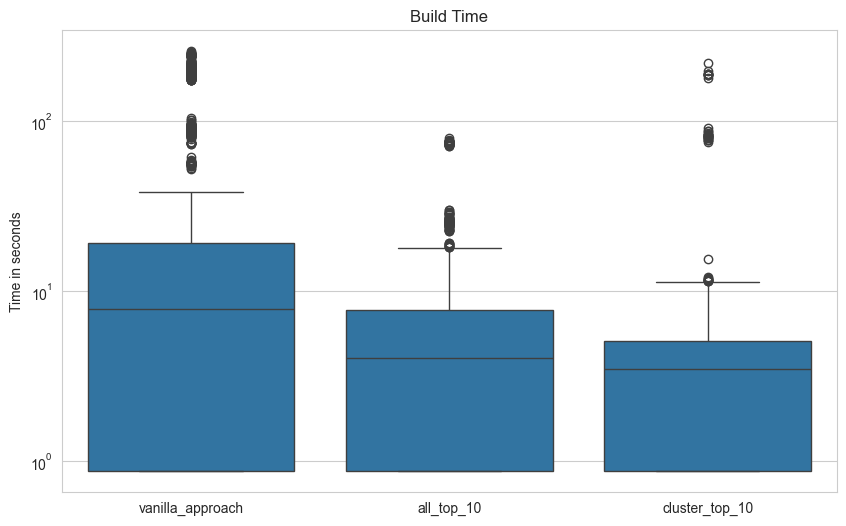

In [319]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='what', y='values', data=toplot)
plt.xlabel('')
plt.ylabel('Time in seconds')
plt.title('Build Time')
plt.yscale('log')
#plt.yticks([0.5, 1, 3, 5],[0.5, 1, 3, 5])
plt.show()

In [320]:
toplot = pd.DataFrame({'values': pd.concat([vanilla_approach.installtime, all_top_10.installtime, cluster_top_10.installtime], ignore_index=True), 'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + ['cluster_top_10'] * len(cluster_top_10)})
toplot = toplot[toplot['values']>-1]

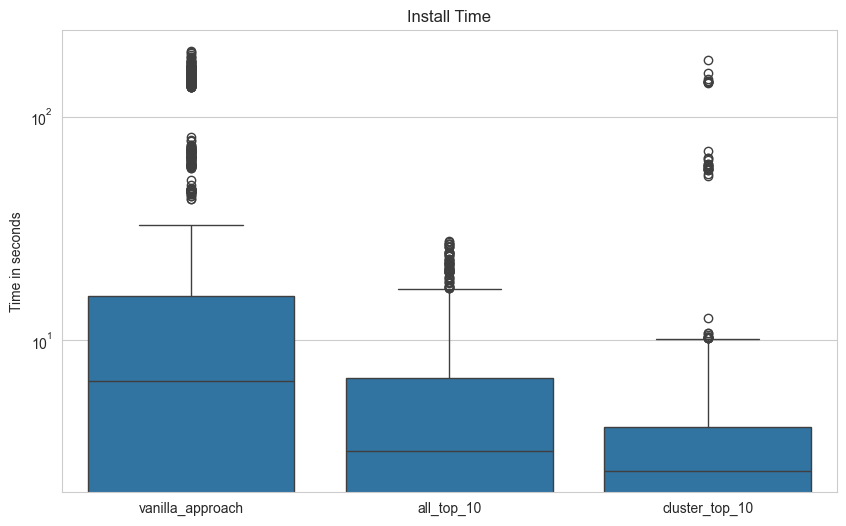

In [321]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='what', y='values', data=toplot)
plt.xlabel('')
plt.ylabel('Time in seconds')
plt.title('Install Time')
plt.yscale('log')
#plt.yticks([0.5, 1, 3, 5],[0.5, 1, 3, 5])
plt.show()

In [322]:
plot_build = pd.DataFrame({'values': pd.concat([vanilla_approach.buldingtime, all_top_10.buldingtime, cluster_top_10.buldingtime], ignore_index=True), 'what': ['Naïve'] * len(vanilla_approach) + ['All Top 10'] * len(all_top_10) + ['Cluster Top 10'] * len(cluster_top_10)})

plot_install = pd.DataFrame({'values': pd.concat([vanilla_approach.installtime, all_top_10.installtime, cluster_top_10.installtime], ignore_index=True), 'what': ['Naïve'] * len(vanilla_approach) + ['All Top 10'] * len(all_top_10) + ['Cluster Top 10'] * len(cluster_top_10)})
plot_install = plot_install[plot_install['values']>-1]


toplot = pd.DataFrame(pd.concat([plot_build, plot_install], ignore_index=True))
toplot['exp'] = ['Build Time'] * len(plot_build) + ['Install Time'] * len(plot_install) 

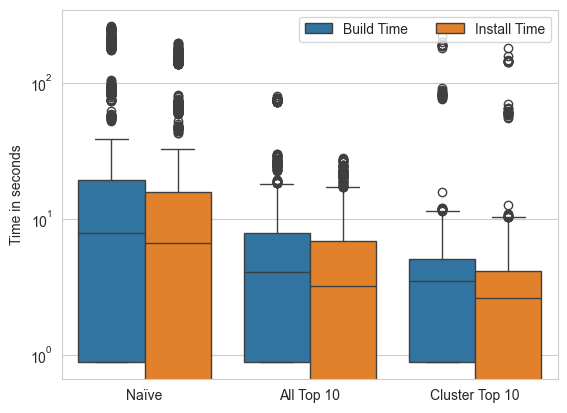

In [323]:
sns.set_style("whitegrid")
sns.boxplot(x='what', y='values', hue='exp', data=toplot)
plt.xlabel('')
plt.ylabel('Time in seconds')
plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), shadow=False, ncol=2)

plt.savefig('figures/buildtime.pdf', format='pdf')

# Show the plot
plt.show()

In [324]:
#toplot = pd.DataFrame({'values': pd.concat([vanilla_approach.starttime, all_top_10.starttime, cluster_top_10.starttime], ignore_index=True), 'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + ['cluster_top_10'] * len(cluster_top_10)})
toplot = pd.DataFrame({'values': pd.concat([vanilla_approach['starttime1'], vanilla_approach['starttime2'], vanilla_approach['starttime3'], vanilla_approach['starttime4'], vanilla_approach['starttime5'],
               all_top_10['starttime1'], all_top_10['starttime2'], all_top_10['starttime3'], all_top_10['starttime4'], all_top_10['starttime5'],
                cluster_top_10['starttime1'], cluster_top_10['starttime2'], cluster_top_10['starttime3'], cluster_top_10['starttime4'], cluster_top_10['starttime5'],
               on_the_fly['starttime1'], on_the_fly['starttime2'], on_the_fly['starttime3'], on_the_fly['starttime4'], on_the_fly['starttime5']], ignore_index=True), 
            'what': ['Naïve'] * 5 * len(vanilla_approach) + ['All Top 10'] * 5 * len(all_top_10) + ['Cluster Top 10'] * 5 * len(cluster_top_10) + ['On-the-fly'] * 5 * len(cluster_top_10)})

toplot['values'] = toplot['values'] * 1000

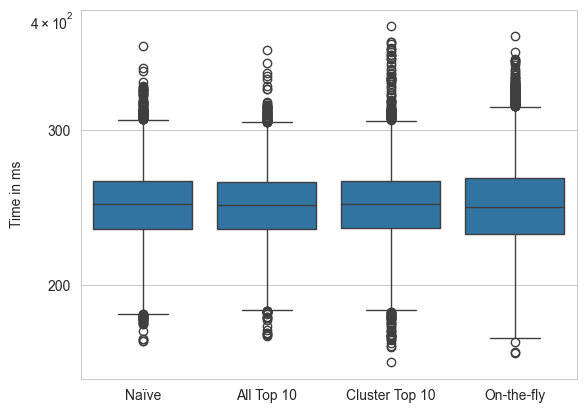

In [325]:
sns.set_style("whitegrid")
#plt.figure(figsize=(10, 6))
sns.boxplot(x='what', y='values', data=toplot)
plt.xlabel('')
plt.ylabel('Time in ms')
plt.yscale('log')
plt.yticks([200, 300],[200, 300])

plt.savefig('figures/start.pdf', format='pdf')

plt.show()

In [326]:
toplot = pd.DataFrame({'values': pd.concat([vanilla_approach.importtime, all_top_10.importtime, cluster_top_10.importtime], ignore_index=True), 'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + ['cluster_top_10'] * len(cluster_top_10)})

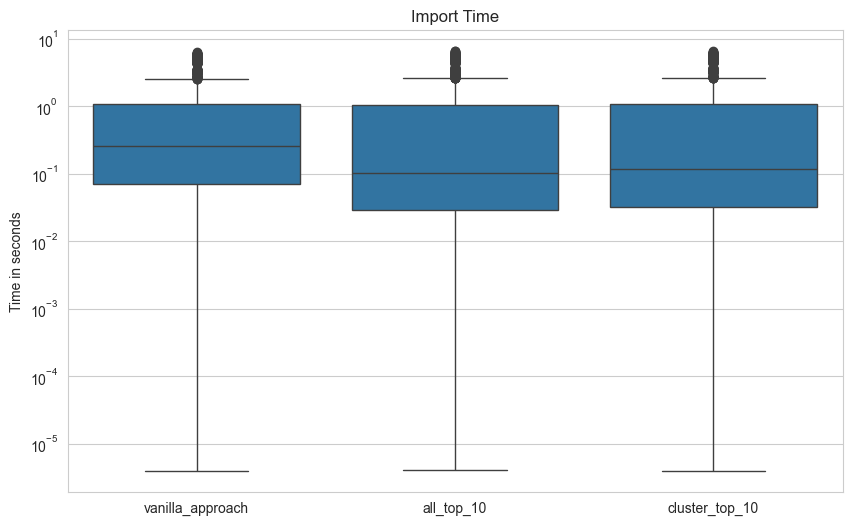

In [327]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='what', y='values', data=toplot)
plt.xlabel('')
plt.ylabel('Time in seconds')
plt.title('Import Time')
plt.yscale('log')
#plt.yticks([0.5, 1, 3, 5],[0.5, 1, 3, 5])
plt.show()

In [328]:
plot_start = pd.DataFrame({'values': pd.concat([vanilla_approach['starttime1'], vanilla_approach['starttime2'], vanilla_approach['starttime3'], vanilla_approach['starttime4'], vanilla_approach['starttime5'],
               all_top_10['starttime1'], all_top_10['starttime2'], all_top_10['starttime3'], all_top_10['starttime4'], all_top_10['starttime5'],
               cluster_top_10['starttime1'], cluster_top_10['starttime2'], cluster_top_10['starttime3'], cluster_top_10['starttime4'], cluster_top_10['starttime5']], ignore_index=True), 
            'what': ['Naïve'] * 5 * len(vanilla_approach) + ['All Top 10'] * 5 * len(all_top_10) + ['Cluster Top 10'] * 5 * len(cluster_top_10)})

plot_import = pd.DataFrame({'values': pd.concat([vanilla_approach.importtime, all_top_10.importtime, cluster_top_10.importtime], ignore_index=True), 'what': ['Naïve'] * len(vanilla_approach) + ['All Top 10'] * len(all_top_10) + ['Cluster Top 10'] * len(cluster_top_10)})



toplot = pd.DataFrame(pd.concat([plot_start, plot_import], ignore_index=True))
toplot['exp'] = ['Start Time'] * len(plot_start) + ['Import Time'] * len(plot_import) 

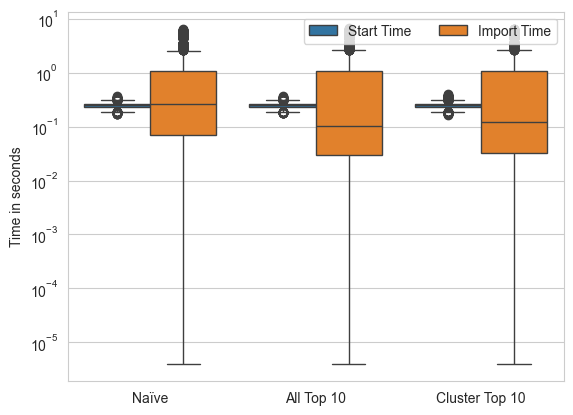

In [329]:
sns.set_style("whitegrid")
sns.boxplot(x='what', y='values', hue='exp', data=toplot)
plt.xlabel('')
plt.ylabel('Time in seconds')
plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), shadow=False, ncol=2)

plt.savefig('figures/start_import.pdf', format='pdf')

# Show the plot
plt.show()

In [330]:
install = pd.read_csv("experiments/installations.csv")
install_libaries = pd.DataFrame()
for index, row in install.iterrows():
    if pd.isna(row[1]):
        ins = set()
    else: 
        ins = set(row[1].split(";"))
    all = set(row[2].split(";"))
    if pd.isna(row[3]):
        clu = set()
    else: 
        clu = set(row[3].split(";"))
    install_libaries = pd.concat([install_libaries, pd.DataFrame([[len(ins), len(ins.intersection(all)), len(ins.intersection(clu)), len(all), len(clu)]])], ignore_index=True)
install_libaries.columns = ['toInstall', 'AlreayInstalled_all', 'AlreayInstalled_cluster', 'Installed_all', 'Installed_cluster']

install_libaries.head()

/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_56715/1746028317.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(row[1]):
/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_56715/1746028317.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ins = set(row[1].split(";"))
/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_56715/1746028317.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all

,toInstall,AlreayInstalled_all,AlreayInstalled_cluster,Installed_all,Installed_cluster
0,7,3,7,10,10
1,6,2,6,10,10
2,1,0,1,10,10
3,1,0,1,10,11
4,1,0,1,10,11


In [331]:
install_libaries = install_libaries[install_libaries.toInstall>0]
print(install_libaries.toInstall.describe())
print((install_libaries.toInstall - install_libaries.AlreayInstalled_all).describe())
print((install_libaries.toInstall - install_libaries.AlreayInstalled_cluster).describe())

count    149.000000
mean       1.993289
std        1.402202
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: toInstall, dtype: float64
count    149.000000
mean       0.791946
std        0.960540
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        5.000000
dtype: float64
count    149.000000
mean       0.067114
std        0.300100
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
dtype: float64


In [332]:
tmp = (install_libaries.toInstall - install_libaries.AlreayInstalled_cluster)
len(tmp[tmp==0])/len(tmp)

0.9463087248322147

In [333]:
print((install_libaries.Installed_all - install_libaries.toInstall).describe())
tmp = install_libaries.Installed_cluster - install_libaries.toInstall
print(tmp[tmp>0].describe())

count    149.000000
mean       8.006711
std        1.402202
min        3.000000
25%        8.000000
50%        9.000000
75%        9.000000
max        9.000000
dtype: float64
count    132.000000
mean       6.931818
std        2.801835
min        1.000000
25%        5.000000
50%        8.000000
75%        9.000000
max       10.000000
dtype: float64


In [334]:
size_vanilla = pd.read_csv("data/vanilla_approach/size.csv", header=None)
size_cluster_top_10 = pd.read_csv("data/cluster_top_10/size.csv", header=None)
size_all_top_10 = pd.read_csv("data/all_top_10/size.csv", header=None)
size_onthefly = 1.01

In [335]:
size_vanilla[1] = [float(re.sub(r'GB$', '', size)) for size in size_vanilla[1]]
size_cluster_top_10[1] = [float(re.sub(r'GB$', '', size)) for size in size_cluster_top_10[1]]
size_all_top_10[1] = [float(re.sub(r'GB$', '', size)) for size in size_all_top_10[1]]

In [336]:
print(pd.DataFrame({'values' : size_vanilla[1].repeat(vanilla_approach_func['count'].iloc[0:207])}).describe())
print(pd.DataFrame({'values' : size_all_top_10[1].repeat(vanilla_approach_func['count'].iloc[0:207])}).describe())
print(pd.DataFrame({'values' : size_cluster_top_10[1].repeat(vanilla_approach_func['count'].iloc[0:207])}).describe())

            values
count  1219.000000
mean      1.724643
std       1.598838
min       1.010000
25%       1.010000
50%       1.020000
75%       1.250000
max       7.330000
            values
count  1219.000000
mean      8.466013
std       0.092961
min       8.450000
25%       8.450000
50%       8.450000
75%       8.450000
max       9.560000
            values
count  1219.000000
mean      3.318958
std       2.436412
min       1.010000
25%       1.250000
50%       1.580000
75%       6.370000
max       7.330000


In [337]:
#func_mapping.head()

In [338]:
#task_mapping = pd.read_csv("funcx/task_function_mapping.csv")
#task_mapping.head()

In [339]:
#funcs = pd.merge(func_mapping, task_mapping, on="func4.name")
#funcs.shape

In [340]:
#counts = funcs.imports.value_counts()
#counts = pd.DataFrame(counts)
#counts.reset_index(inplace=True)
#counts = counts._append({'imports': "argparse;copy;datetime;funcx;itertools;json;matplotlib;numpy;os;pathlib;shutil;sys;threading;typing", 'count': 1}, ignore_index=True)
#counts.tail()

In [341]:
#install_libaries['imports'] = install.imports
#install_libaries.head()

In [342]:
#df = pd.merge(install_libaries[install_libaries.toInstall>0], counts, on="imports")
#df.head()

In [343]:
#print(pd.DataFrame({'values' : df.toInstall.repeat(df['count'])}).describe())
#print(pd.DataFrame({'values' : (df.toInstall - df.AlreayInstalled_all).repeat(df['count'])}).describe())
#print(pd.DataFrame({'values' : (df.toInstall - df.AlreayInstalled_cluster).repeat(df['count'])}).describe())

In [344]:
#install_libaries[install_libaries.toInstall>0].describe()

In [345]:
max_start = max(itertools.chain.from_iterable([vanilla_approach[f'starttime{i+1}'] for i in range(5)]))

plot_start = pd.DataFrame({'values': pd.concat([vanilla_approach['starttime1']/max_start, vanilla_approach['starttime2']/max_start, vanilla_approach['starttime3']/max_start, vanilla_approach['starttime4']/max_start, vanilla_approach['starttime5']/max_start, all_top_10['starttime1']/max_start, all_top_10['starttime2']/max_start, all_top_10['starttime3']/max_start, all_top_10['starttime4']/max_start, all_top_10['starttime5']/max_start,
               cluster_top_10['starttime1']/max_start, cluster_top_10['starttime2']/max_start, cluster_top_10['starttime3']/max_start, cluster_top_10['starttime4']/max_start, cluster_top_10['starttime5']/max_start], ignore_index=True), 
            'what': ['vanilla_approach'] * 5 * len(vanilla_approach) + ['all_top_10'] * 5 * len(all_top_10) + ['cluster_top_10'] * 5 * len(cluster_top_10)})

plot_build = pd.DataFrame({'values': pd.concat([vanilla_approach.buldingtime/max(vanilla_approach.buldingtime), all_top_10.buldingtime/max(vanilla_approach.buldingtime), cluster_top_10.buldingtime/max(vanilla_approach.buldingtime)], ignore_index=True), 'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + ['cluster_top_10'] * len(cluster_top_10)})

plot_install = pd.DataFrame({'values': pd.concat([vanilla_approach.installtime/max(vanilla_approach.installtime), all_top_10.installtime/max(vanilla_approach.installtime), cluster_top_10.installtime/max(vanilla_approach.installtime)], ignore_index=True), 'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + ['cluster_top_10'] * len(cluster_top_10)})
plot_install = plot_install[plot_install['values']>-1]

plot_import = pd.DataFrame({'values': pd.concat(
    [vanilla_approach.importtime/max(vanilla_approach.importtime), all_top_10.importtime/max(vanilla_approach.importtime), cluster_top_10.importtime/max(vanilla_approach.importtime)], ignore_index=True),
                       'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + [
                           'cluster_top_10'] * len(cluster_top_10)})

toplot = pd.DataFrame(pd.concat([plot_build, plot_install, plot_start, plot_import], ignore_index=True))
toplot['exp'] = ['Build'] * len(plot_build) + ['Install'] * len(plot_install) + ['Start'] * len(plot_start) + ['Import'] * len(plot_import)

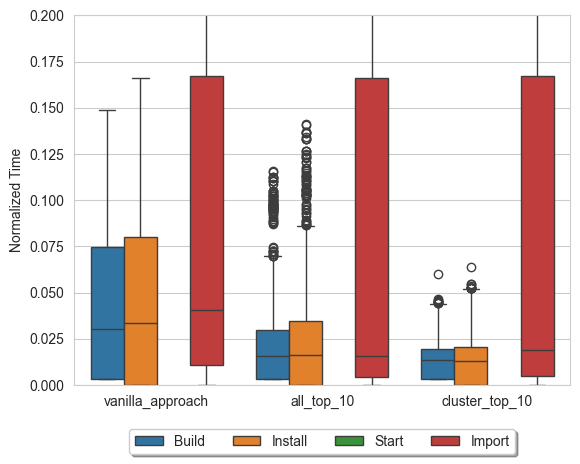

In [346]:
sns.boxplot(x='what', y='values', hue='exp', data=toplot)
plt.xlabel('')
plt.ylabel('Normalized Time')
#plt.yscale('log')
plt.ylim(0,0.2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=4)
# Show the plot
plt.show()